In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt





C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:

# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [4]:
# Define the data directory
# data_dir = '../../Anchor_images/'
# data_dir = '../test/'

data_dir = './new_stuff/test/'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x]) for x in ['test','train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
print(dataset_sizes)

class_names = image_datasets['test'].classes
print(class_names)
print(len(class_names))

{'test': 3097}
['attack', 'benign']
2


In [5]:
# pretrained_model = "custom_cnn_model_new_stuffing.pth"
pretrained_model = "custom_cnn_model_new_stuffing 1.pth"
# use_cuda=True
# Set random seed for reproducibility
# torch.manual_seed(42)
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Freeze all layers except the final classification layer
# for name, param in model.named_parameters():
#     # Unfreeze the final classification layer
#     if "fc" in name:  
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
# Modify the final layer to match the number of classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(pretrained_model))
model.eval()
model = model.to(device)

print(device)

C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [6]:

def calculate_accuracy2(all_preds, all_labels):
    # acc1 = label = 0 and pred = 1 / label = 0
    # acc2 = label = 1 and pred = 1 / label = 1
    # print acc1 as benign to attack accuracy
    # print acc2 as attack to attack accuracy

    confusion_matrix = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            confusion_matrix[i][j] = ((all_preds == i) & (all_labels == j)).sum().item()
    # print(confusion_matrix)
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.title('Original Confusion Matrix')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(int(confusion_matrix[i][j])), ha='center', va='center', color='black')


    acc1 = (all_preds[all_labels == 0] == 1).sum().item() / (all_labels == 0).sum().item()
    acc2 = (all_preds[all_labels == 1] == 1).sum().item() / (all_labels == 1).sum().item()
    print("1. Benign to benign model accuracy: ", acc1)
    print("2. Attack to benign model accuracy: ", acc2)
    # original confusion matrix
    # plot confusion matrix
    confusion_matrix_0 = np.zeros((1, 2))
    confusion_matrix_1 = np.zeros((1, 2))
    confusion_matrix_0[0, 0] = ((all_preds == 0) & (all_labels == 0)).sum().item() # True Negative (benign as benign)
    confusion_matrix_0[0, 1] = ((all_preds == 1) & (all_labels == 0)).sum().item() # False Positive (benign as attack)
    
    confusion_matrix_1[0, 0] = ((all_preds == 0) & (all_labels == 1)).sum().item() # False Negative (attack as benign)
    confusion_matrix_1[0, 1] = ((all_preds == 1) & (all_labels == 1)).sum().item() # True Positive (attack as attack)
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(confusion_matrix_0, cmap='Blues', interpolation='nearest')
    ax[0].set_xlabel('Predictions (0: benign, 1: attack)')
    ax[0].set_ylabel('True Attack')
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([])
    # ax
    # plot number of samples in each cell
    for i in range(1):
        for j in range(2):
            ax[0].text(j, i, str(int(confusion_matrix_0[i][j])), ha='center', va='center', color='black')
    ax[0].set_title('1. Benign to benign model')
    
    ax[1].imshow(confusion_matrix_1, cmap='Blues', interpolation='nearest')
    ax[1].set_xlabel('Predictions (0: benign, 1: attack)')
    ax[1].set_ylabel('True Attack')
    ax[1].set_xticks([0, 1])
    ax[1].set_yticks([])
    # plot number of samples in each cell
    for i in range(1):
        for j in range(2):
            ax[1].text(j, i, str(int(confusion_matrix_1[i][j])), ha='center', va='center', color='black')
    ax[1].set_title('2. Attack to Benign model')
    plt.show()
    
    
    return acc1, acc2


In [7]:
# test_loader = dataloaders['test']
# all_preds = []
# all_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     with torch.no_grad():
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#     all_preds.extend(preds.cpu().numpy())
#     all_labels.extend(labels.cpu().numpy())

# # Convert lists to numpy arrays
# all_preds = np.array(all_preds)
# all_labels = np.array(all_labels)

# # Calculate accuracy
# test_accuracy = np.sum(all_preds == all_labels) / len(all_labels)
# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Accuracy2: {calculate_accuracy2(all_preds, all_labels):.4f}')

In [8]:
# # Calculate the confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [9]:
# print(all_preds)
# print(all_labels)

In [10]:
def stuff_bits(binary_string):
    """
    Inserting '1' after every 5 consecutive '0's in the binary string.

    Args:
        binary_string (str): Binary string to be stuffed.

    Returns:
        str: Binary string after stuffing.

    """
    result = ''

    # Initialize a count for consecutive 0's
    count = 0

    for bit in binary_string:

        # Appending the current bit to the result string
        result += bit
        
        # Incrementing the count if the current bit is 0
        if bit == '0':
            count += 1
            
            # Inserting a 1 after 5 consecutive 0's
            if count == 5:
                result += '1'
                # Reseting the count after inserting the 1
                count = 0
        else:
            # Reseting the count if the current bit is not 0
            count = 0

    return result

def save_image(img, name):
    to_pil = transforms.ToPILImage()
    img = to_pil(img)
    img.save(name)

In [11]:
# FGSM attack code
bit_pattern = '00010011000000011000'
# bit_pattern = bit_stuff(bit_pattern)
# after stuffing 
bit_pattern = '000100110000010011000'
assert bit_pattern == '000100110000010011000'

def generate_mask_modify(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # Convert the bit pattern to a corresponding RGB pattern
    # print(bit_pattern)
    # 0000010001001100000100
    rgb_pattern = [(0.0, 0.0, 0.0) if bit == '0' else (1.0, 1.0, 1.0) for bit in bit_pattern]

    # Extract relevant length of rows
    pattern_length = len(rgb_pattern)
    start_bit = len(bit_pattern)
    mask_length = 64

    # Initialize a mask to zero
    mask = torch.zeros_like(data_grad)

    for i in range(image.shape[2]):  # iterate over rows
        # Check if the first pixels in the row match the desired pattern
        matches_pattern = torch.ones(image.shape[0], dtype=torch.bool, device=image.device)
        # print first 26 pixels as bits of current row
        # print(image[:, 0, i, :26])
        for j in range(pattern_length):
            r, g, b = rgb_pattern[j]
            # print(image[:, 0, i, j], r,image[:, 0, i, j]==r )
            # print(image[:, 1, i, j], g,image[:, 1, i, j]==g )
            # print(image[:, 2, i, j], b,image[:, 2, i, j]==b )
            # s
            matches_pattern &= (image[:, 0, i, j] == r) & (image[:, 1, i, j] == g) & (image[:, 2, i, j] == b)

        
        # Apply the mask for rows that match the pattern
        if matches_pattern.any():
            for b in range(image.shape[0]):
                if matches_pattern[b]:
                    mask[b, :, i, start_bit:start_bit + mask_length] = 1  # Applying mask from 27th bit to next 64 bits
    # for b in range(image.shape[0]):
    #     # plt.figure(figsize=(15, 5))
    #     # plt.subplot(1, 3, 1)
    #     # plt.imshow(image[b].detach().cpu().permute(1, 2, 0).numpy())
    #     # plt.title('Original Image')
    #     # plt.axis('off')
        
    #     # Plot the perturbed image
    #     # bit_pattern = '00000100010011000001001000'
    #     pattern_length = len(bit_pattern)
        
    #     for b in range(image.shape[0]):
    #         # Create a pattern image based on the bit pattern
    #         height, width = image.shape[2], image.shape[3]
    #         pattern_image = np.zeros((height, width, 3), dtype=np.float32)

    #         # Set the RGB values based on the bit pattern
    #         for j, bit in enumerate(bit_pattern):
    #             if bit == '1':
    #                 pattern_image[:, j] = [1.0, 1.0, 1.0]  # White pixel
    #             else:
    #                 pattern_image[:, j] = [0.0, 0.0, 0.0]  # Black pixel
        # plt.subplot(1, 3, 2)
        # plt.imshow(pattern_image)
        # plt.title('pattern_image')
        # plt.axis('off')


        # # Plot the mask
        # plt.subplot(1, 3, 3)
        # plt.imshow(mask[b].detach().cpu().permute(1, 2, 0).numpy(), cmap='gray')
        # plt.title('Mask')
        # plt.axis('off')

        # # Show the plots
        # plt.show()
        # p = input()
    return mask

def generate_mask_insertion(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format
    
    # Extract the red, green, and blue channels
    red_channel = image[:, 0, :, :]
    green_channel = image[:, 1, :, :]
    blue_channel = image[:, 2, :, :]
    
    # Create a mask for rows where all pixels are exactly (0, 1, 0) - i.e., green
    green_mask = (red_channel == 0) & (green_channel == 1) & (blue_channel == 0)
    
    # Initialize variables to track the maximum gradient and corresponding row index
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified row
    
    return mask


def generate_mask_multiple_insertion(image, data_grad):
    numberofrows = 5
    # Assuming 'image' is of shape [batch_size, 3, height, width]
    batch_size, _, height, width = image.shape

    # Extract the red, green, and blue channels
    red_channel = image[:, 0, :, :]
    green_channel = image[:, 1, :, :]
    blue_channel = image[:, 2, :, :]
    
    # Create a mask for rows where all pixels are exactly (0, 1, 0) - i.e., green
    green_mask = (red_channel == 0) & (green_channel == 1) & (blue_channel == 0)
    
    # Sum along the width dimension to find rows with green pixels
    row_sums = green_mask.sum(dim=-1)
    
    # Get indices of rows with green pixels
    rows_with_green = (row_sums > 0).nonzero(as_tuple=True)[1]
    
    # Randomly select 'numberofrows' rows from rows_with_green
    if len(rows_with_green) > numberofrows:
        selected_rows = torch.randperm(len(rows_with_green))[:numberofrows]
        selected_rows = rows_with_green[selected_rows]
    else:
        selected_rows = rows_with_green

    # Initialize a mask of zeros
    mask = torch.zeros_like(image, dtype=torch.float)
    
    # Set selected rows to 1
    for row in selected_rows:
        mask[:, :, row, :] = 1.0

    return mask

def fgsm_attack_modify(image, epsilon, data_grad, n):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # sign_data_grad = data_grad
    
    # Create a mask to apply sign data grad only in the rows with max gradient magnitude
    mask = generate_mask_modify(image, data_grad)
    mask2 = generate_mask_multiple_insertion(image, data_grad)
    mask = mask + mask2

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified rows' pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        # print(mask[b,0])
        # print(mask[b,0].nonzero())
        
        rows = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row indices
        rows = torch.unique(rows)
        # print(rows)
        for row in rows:
            for col in range(len(bit_pattern), len(bit_pattern)+64):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)
        # if len(rows)!=0:
        #     print('Matched', len(rows))
        #     plt.figure(figsize=(15, 5))
        #     plt.subplot(1, 3, 1)
        #     plt.imshow(image[b].detach().cpu().permute(1, 2, 0).numpy())
        #     save_image(image[b].detach().cpu(), f'original_modify_{b}.png')
        #     plt.title('Original Image')
        #     plt.axis('off')
            
        #     # Plot the perturbed image
        #     plt.subplot(1, 3, 2)
        #     plt.imshow(perturbed_image[b].detach().cpu().permute(1, 2, 0).numpy())
        #     save_image(perturbed_image[b].detach().cpu(), f'perturbed_modify_{b}.png')
        #     plt.title('Perturbed Image')
        #     plt.axis('off')

        #     # Plot the mask
        #     plt.subplot(1, 3, 3)
        #     plt.imshow(mask[b].detach().cpu().permute(1, 2, 0).numpy(), cmap='gray')
        #     save_image(mask[b].detach().cpu(), f'mask_modify_{b}.png')
        #     plt.title('Mask')
        #     plt.axis('off')

        #     # Show the plots
        #     plt.show()
        #     f
        # plt.subplot(1, 2, 1)
        # plt.imshow(perturbed_image[b,:,:,:].detach().cpu().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
        # plt.axis('off')

        # plt.subplot(1, 2, 2)

        # plt.imshow(mask[b,:,:,:].detach().cpu().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])

        # sd        
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    red_channel = image[:, 0, :, :]
    green_channel = image[:, 1, :, :]
    blue_channel = image[:, 2, :, :]
    
    # Create a mask for rows where all pixels are exactly (0, 1, 0) - i.e., green
    green_mask = (red_channel == 0) & (green_channel == 1) & (blue_channel == 0)
    
    # Initialize variables to track the maximum gradient and corresponding row index
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified row
    
    return mask

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    sign_data_grad = data_grad
    
    # create a mask to apply sign data grad only in the row with max gradient magnitude
    mask = generate_mask(image, data_grad)

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified row's pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        row = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row index
        if len(row) > 0:  # Only apply if a row is identified
            row = row[0].item()
            for col in range(image.shape[3]):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)

    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

def bit_stuff(data):
    stuffed = ""
    count = 0
    for bit in data:
        if bit == '1':
            count += 1
            stuffed += bit
            if count == 5:
                stuffed += '0'
                count = 0
        else:
            stuffed += bit
            count = 0
    return stuffed

def crc_remainder(input_bitstring, polynomial_bitstring, initial_filler):
    polynomial_bitstring = polynomial_bitstring.lstrip('0')
    len_input = len(input_bitstring)
    initial_padding = initial_filler * (len(polynomial_bitstring) - 1)
    input_padded_array = list(input_bitstring + initial_padding)
    
    while '1' in input_padded_array[:len_input]:
        cur_shift = input_padded_array.index('1')
        for i in range(len(polynomial_bitstring)):
            input_padded_array[cur_shift + i] = \
                str(int(polynomial_bitstring[i] != input_padded_array[cur_shift + i]))
                
    return ''.join(input_padded_array)[len_input:]




# import torch

def generate_mask_N(image, data_grad, n):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # Extract the green channel
    red_channel = image[:, 0, :, :]
    green_channel = image[:, 1, :, :]
    blue_channel = image[:, 2, :, :]
    
    # Create a mask for rows where all pixels are exactly (0, 1, 0) - i.e., green
    green_mask = (red_channel == 0) & (green_channel == 1) & (blue_channel == 0)
    
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    # green_mask = green_channel > 0.5
    
    # Initialize variables to track the maximum and second maximum gradient and corresponding row indices
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    second_max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    second_max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the rows with max and second max gradient magnitudes if they have all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        second_update_mask = (row_grad_magnitude > second_max_grad) & all_green & ~update_mask
        
        # Update second max row if the current max row is changing
        second_max_grad = torch.where(update_mask, max_grad, torch.where(second_update_mask, row_grad_magnitude, second_max_grad))
        second_max_grad_row = torch.where(update_mask, max_grad_row, torch.where(second_update_mask, torch.tensor(i, device=image.device), second_max_grad_row))
        
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max and second max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified max row
        mask[b, :, second_max_grad_row[b], :] = 1  # Applying on all columns of the identified second max row
    
    return mask

def generate_mask_3(image, data_grad, n):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # Extract the green channel
    red_channel = image[:, 0, :, :]
    green_channel = image[:, 1, :, :]
    blue_channel = image[:, 2, :, :]
    
    # Create a mask for rows where all pixels are exactly (0, 1, 0) - i.e., green
    green_mask = (red_channel == 0) & (green_channel == 1) & (blue_channel == 0)
    
    # Initialize variables to track the maximum and second maximum gradient and corresponding row indices
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    second_max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    second_max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the rows with max and second max gradient magnitudes if they have all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        second_update_mask = (row_grad_magnitude > second_max_grad) & all_green & ~update_mask
        
        # Update second max row if the current max row is changing
        second_max_grad = torch.where(update_mask, max_grad, torch.where(second_update_mask, row_grad_magnitude, second_max_grad))
        second_max_grad_row = torch.where(update_mask, max_grad_row, torch.where(second_update_mask, torch.tensor(i, device=image.device), second_max_grad_row))
        
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max and second max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified max row
        mask[b, :, second_max_grad_row[b], :] = 1  # Applying on all columns of the identified second max row
    
    return mask

def fgsm_attack_N(image, epsilon, data_grad, n):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # sign_data_grad = data_grad
    
    # Create a mask to apply sign data grad only in the rows with max gradient magnitude
    mask = generate_mask_N(image, data_grad, n)

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified rows' pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        # print(mask[b,0])
        # print(mask[b,0].nonzero())
        
        rows = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row indices
        rows = torch.unique(rows)
        # print(rows)
        for row in rows:
            fixed_pattern = "00000100010011000001001000"
            for i, bit in enumerate(fixed_pattern):
                value = 1.0 if bit == '1' else 0.0
                perturbed_image[b, :, row, i] = value
                # colored black or white

            # Perturbation bits from 27th to 90th pixels
            perturbation_bits = ''.join(['1' if perturbed_image[b, 0, row, 26 + i] > 0.5 else '0' for i in range(64)])

            for col in range(26, 26+64):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)

            # Calculate CRC
            crc_input = '0' + '0000000100110000' + '0' + '0' + '0' + '1' + '1000' + perturbation_bits
            crc_output = crc_remainder(crc_input, '100000111', '0')
            bit_stuffed_crc = bit_stuff(crc_output[:15])

            # Apply bit-stuffed CRC to the next 15 pixels
            for i, bit in enumerate(bit_stuffed_crc):
                value = 1.0 if bit == '1' else 0.0
                perturbed_image[b, :, row, 26 + 64 + i] = value

            ending_part = '1011111111111'
            for i, bit in enumerate(ending_part):
                value = 1.0 if bit == '1' else 0.0
                perturbed_image[b, :, row, 26 + 64 +len(ending_part)+ i] = value
            
            # Mark the rest of the pixels in the row as green
            for i in range(26 + 64 + len(ending_part)+len(bit_stuffed_crc), 128):
                perturbed_image[b, 1, row, i] = 1.0  # Set green channel to maximum
                perturbed_image[b, 0, row, i] = 0.0
                perturbed_image[b, 2, row, i] = 0.0
            # for col in range(image.shape[3]):
            #     pixel_value = perturbed_image[b, :, row, col]
            #     dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
            #     dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
            #     if dot_product_with_1 >= dot_product_with_0:
            #         perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
            #     else:
            #         perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)
        # plt.subplot(1, 2, 1)
        # plt.imshow(perturbed_image[b,:,:,:].detach().cpu().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
        # plt.axis('off')

        # plt.subplot(1, 2, 2)

        # plt.imshow(mask[b,:,:,:].detach().cpu().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])

        # sd        
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    return batch
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)



In [12]:


def test( model, device, test_loader, epsilon ):
    test_loader = dataloaders['test']

    # Accuracy counter
    correct = 0
    adv_examples = []
    print(device)
    print(len(test_loader))
    all_preds = []
    all_labels = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # print(target.shape)
        # print(target)
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        model.eval()
        initial_output = model(data)
        # print(output)
        
        init_pred = initial_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print(init_pred)
        # If the initial prediction is wrong, don't bother attacking, just move on
        # print(init_pred.item())
        # print(target.item())

        # if init_pred.squeeze().tolist() != target.tolist():
            # continue

        # Calculate the loss
        loss = F.nll_loss(initial_output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        # output = model(perturbed_data_normalized)
        output = model(perturbed_data)
        # output = initial_output
        # print(output.shape)
        # print(output)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print("final: ", final_pred.item())

        all_preds.extend(final_pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        # if final_pred.squeeze().tolist() == target.tolist():
        #     correct += 1
        #     # Special case for saving 0 epsilon examples
        #     if epsilon == 0 and len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        # else:
        #     # Save some adv examples for visualization later
        #     if len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.squeeze().tolist(), final_pred.squeeze().squeeze(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/float(len(test_loader))
    # print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")
    final_acc = np.sum(all_preds == all_labels) / len(all_labels)
    print(f'Test Accuracy: {final_acc:.4f}')

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
# show an image


In [13]:
def test2( model, device, test_loader, epsilon ):
    """
    accuracy is model incorrectly classifies benign + perturbation as benign image 
    """
    test_loader = dataloaders['test']

    # Accuracy counter
    correct = 0
    total_consider = 0
    adv_examples = []
    print(device)
    print(len(test_loader))
    all_preds = []
    all_labels = []
    # Loop over all examples in test set
    i = 0
    for data, target in test_loader:
        # print(i,len(test_loader))
        i+=1
        # print(target.shape)
        # print(target)
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        model.eval()
        initial_output = model(data)
        # print(output)
        
        init_pred = initial_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print(init_pred)
        # If the initial prediction is wrong, don't bother attacking, just move on
        # print(init_pred.item())
        # print(target.item())
        # if init_pred.squeeze().tolist() != target.tolist() or not all(element == 0 for element in target.tolist()):

        #     # print("not equal")
        #     continue
        total_consider +=1
        # Calculate the loss
        loss = F.nll_loss(initial_output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack_modify(data_denorm, epsilon, data_grad,1)
        # if perturbed_data == data:
        #     continue
        # Reapply normalization
        # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        # output = model(perturbed_data_normalized)
        output = model(perturbed_data)
        # output = initial_output
        # print(output.shape)
        # print(output)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print("final: ", final_pred.item())

        all_preds.extend(final_pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        # if final_pred.squeeze().tolist() == target.tolist():
        #     correct += 1
        #     # Special case for saving 0 epsilon examples
        #     if epsilon == 0 and len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        # else:
        #     # Save some adv examples for visualization later
        #     if len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.squeeze().tolist(), final_pred.squeeze().squeeze(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/total_consider
    # print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total_consider} = {final_acc}")

    # final_acc = calculate_accuracy2(all_preds, all_labels)
    # print(f'Test Accuracy: {final_acc:.4f}')

    # Return the accuracy and an adversarial example
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return all_preds.squeeze(), all_labels

# show an image


10
cuda:0
388
1. Benign to benign model accuracy:  0.17509481668773705
2. Attack to benign model accuracy:  0.9590759075907591


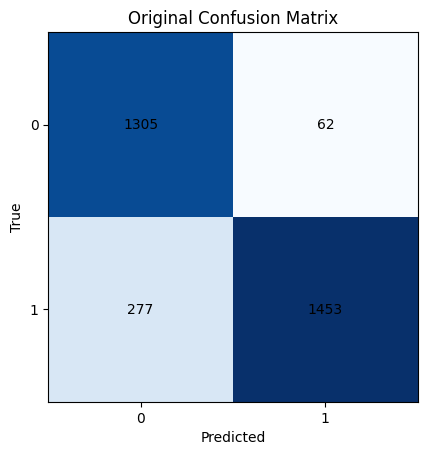

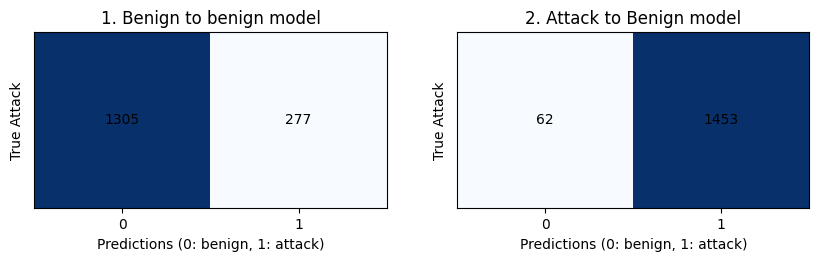

10 0.8905392315143688 (0.17509481668773705, 0.9590759075907591)
1
cuda:0
388


KeyboardInterrupt: 

In [14]:
accuracies = []
examples = []
epsilons = [ 0.1, 0.5, 1, 10]
epsilons.reverse()

test_loader = dataloaders['test']
# Run test for each epsilon
for eps in epsilons:
    # acc, ex = test2(model, device, test_loader, eps)
    print(eps)
    preds, labels = test2(model, device, test_loader, eps)
    acc = np.sum(preds == labels) / len(labels)
    ex = []
    acc2 = calculate_accuracy2(preds, labels)
    print(eps, acc, acc2)
    accuracies.append(acc)
    examples.append(ex)
    

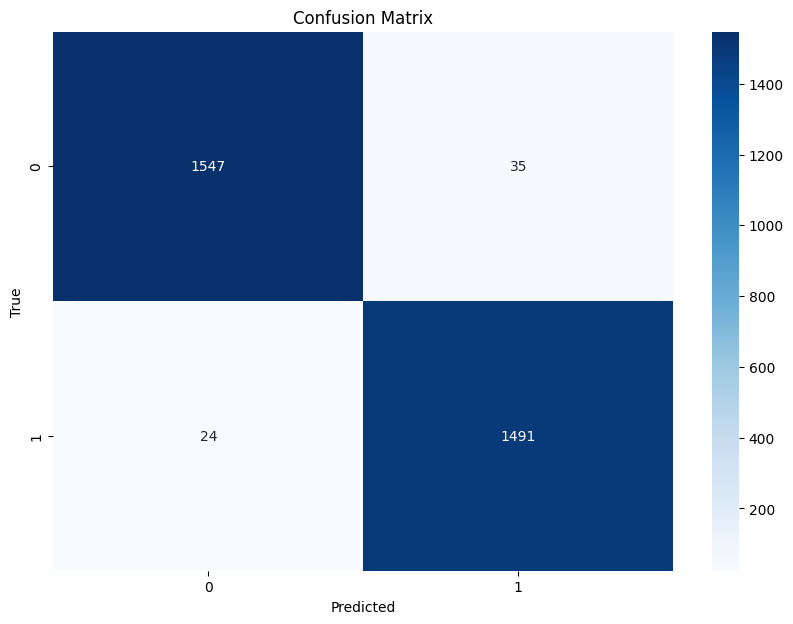

In [42]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print()

In [ ]:
accuracies = []
examples = []
epsilons = [ 100]
# epsilons.reverse()

test_loader = dataloaders['test']
# Run test for each epsilon
for eps in epsilons:
    # acc, ex = test2(model, device, test_loader, eps)
    print(eps)
    preds, labels = test2(model, device, test_loader, eps)
    acc = np.sum(preds == labels) / len(labels)
    ex = []
    acc2 = calculate_accuracy2(preds, labels)
    print(eps, acc, acc2)
    accuracies.append(acc)
    examples.append(ex)
    

100
cuda:0
3097
100 0.9641588634162093 0.9475347661188369


NameError: name 'accuracies' is not defined

In [ ]:
accuracies = []
examples = []
epsilons = [0.1, 0.2, 0.5, 1]

test_loader = dataloaders['test']
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


cuda:0
775


NameError: name 'test_accuracy' is not defined

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])
tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 1., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])


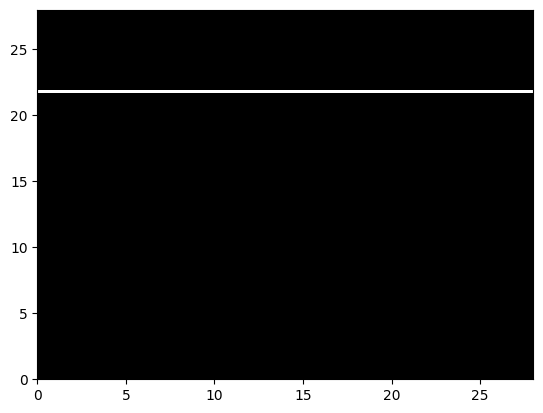

In [ ]:

def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    green_channel = image[:, 1, :, :]
    print(green_channel)
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    green_mask = green_channel > 0.5
    
    # Find the row with maximum gradient magnitude where all pixels are green
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[2]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the middle column of the identified row
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying to all rows
        
    return mask
# show first image in dataset
img1 = dataloaders['test'].dataset[10][0]
print(img1.shape)
# print(img1)
print(img1.permute(1, 2, 0).shape)

plt.imshow(img1.permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
# genarate mask and visualize it
img1 = img1.unsqueeze(0)
gradsss = torch.rand_like(img1).contiguous()
gradsss = gradsss-0.5
maskss = generate_mask(img1,gradsss)
plt.imshow(maskss.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


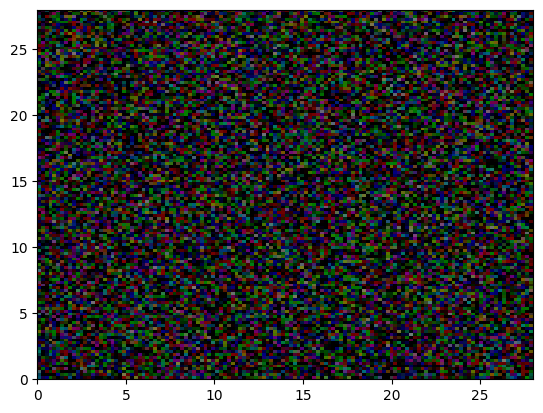

In [ ]:
plt.imshow(gradsss.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


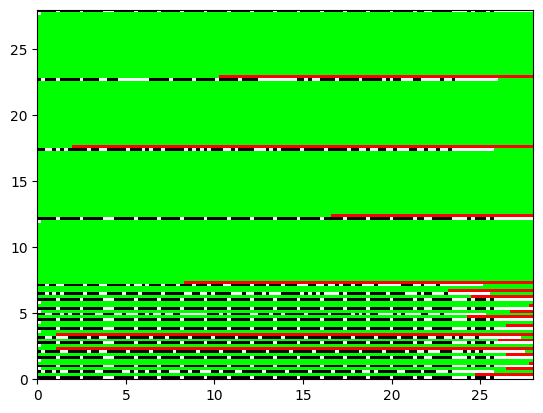

In [ ]:
plt.imshow(gradsss.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
plt.imshow(img1.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


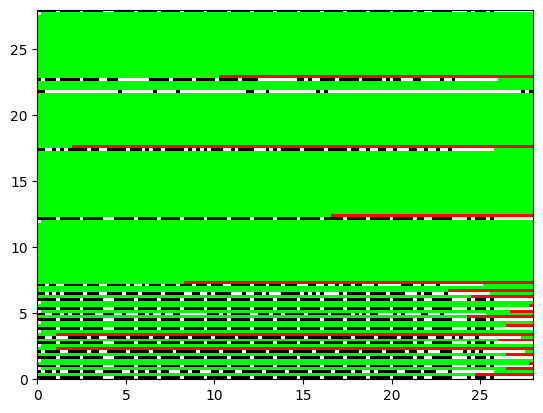

In [ ]:
import torch

def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    green_channel = image[:, 1, :, :]
    
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    green_mask = green_channel > 0.5
    
    # Initialize variables to track the maximum gradient and corresponding row index
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified row
    
    return mask

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # create a mask to apply sign data grad only in the row with max gradient magnitude
    mask = generate_mask(image, data_grad)

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified row's pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        row = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row index
        if len(row) > 0:  # Only apply if a row is identified
            row = row[0].item()
            for col in range(image.shape[3]):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image
pimg1 = fgsm_attack(img1, 1, gradsss)
plt.imshow(pimg1.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


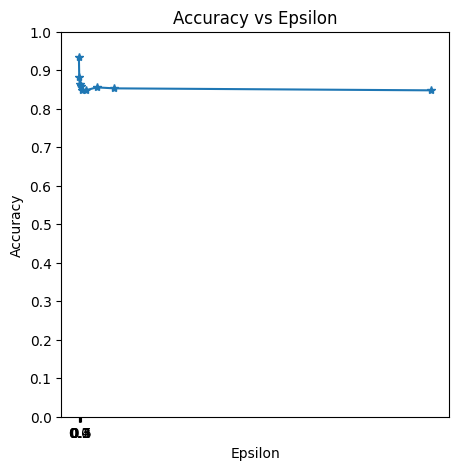

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:], accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

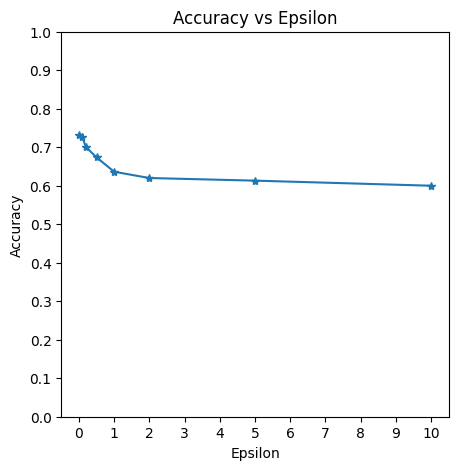

In [ ]:
# plot accuracy vs epsilon
accuracies2 = accuracies[:-1]
epsilons2 = epsilons[:-1]
accuracies2[5] = 0.62
accuracies2[7] = 0.6
plt.figure(figsize=(5,5))
plt.plot(epsilons2, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()